# Boiler Plate
This notebook illustrates how to develop your strategy and run a back-test with [BackTrader](https://www.backtrader.com/) package.

In [1]:
from lib.utils.logging import configure_logger
%load_ext autoreload
%autoreload 2
configure_logger()

ModuleNotFoundError: No module named 'lib'

## Data preparation
Get reday for the data.

In [2]:
from lib.utils.data_utils import load_data

kospi_df = load_data('^KS11')

ModuleNotFoundError: No module named 'lib'

## Develope your strategy
You can develop your strategy in this cell. But I recommend you to develope it in lib.strategies package.
Or you can use something in the package.

You can find how to develope your own strategy [here](https://www.backtrader.com/docu/strategy/).   

## Run back-test.

In [30]:
import backtrader as bt
from datetime import date
from lib.strategies.hold_strategy import HoldStrategy

# Create a backtest runtime
cerebro = bt.Cerebro()
# Add your strategy
cerebro.addstrategy(HoldStrategy, buy_date=date(1997, 1, 3))
# Set your initial budget. You can also "add_cash" in your strategy.
initial_cash = 10000000
cerebro.broker.setcash(10000000)
# You usually pay 0.33% per transaction in the KRX(commission + tax). 
# We will simulate this by setting 0.165% of commission per order.
# So (buy + sell orders = 0.33%) 
cerebro.broker.setcommission(commission=0.00165)
# Create Data Feed from Pandas DF.
kospi_data = bt.feeds.PandasData(dataname=kospi_df, close='Adj Close')
cerebro.adddata(kospi_data, name='KOSPI')
# Data analyzers.
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='draw_down')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positions_value', cash=True, headers=True)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
res = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000000.00
INFO - [1997-07-02] [KOSPI] BUY EXECUTED, Price: 763.39, Cost: 9969873.59, Commission 16450.29
Final Portfolio Value: 25448810.48


## Visualize your strategy

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
cerebro.plot()

<IPython.core.display.Javascript object>

[[<Figure size 1152x576 with 4 Axes>]]

or 
## Analyze the performance by yourself.

In [33]:
%matplotlib inline
import empyrical as ep
import pandas as pd

from lib.utils.analyzer_utils import annual_return_to_df, positions_value_to_df

annual_return_df = annual_return_to_df(res[0].analyzers.annual_return.get_analysis())
positions_value_df = positions_value_to_df(res[0].analyzers.positions_value.get_analysis(), enrich_total=True, total_col_name='total')
sharpe_ratio = res[0].analyzers.sharpe.get_analysis()['sharperatio']
mdd = res[0].analyzers.draw_down.get_analysis()["max"]["drawdown"]
cagr = ep.cagr(positions_value_df['total'].pct_change(), period="daily", annualization=None)
 
report_df = pd.DataFrame(
    dict(
        initial_value = initial_cash,
        final_value = cerebro.broker.get_value(),
        period_start = positions_value_df.index.min(),
        period_end = positions_value_df.index.max(),
        sharpe_ratio = sharpe_ratio,
        mdd = mdd,
        cagr = cagr
    ),
    index=['dual_momentum_w_treasury']
)

pd.set_option('float_format', '{:.3f}'.format)
report_df

,initial_value,final_value,period_start,period_end,sharpe_ratio,mdd,cagr
dual_momentum_w_treasury,10000000,25448810.483,1997-07-01,2020-04-29,0.255,64.095,0.043


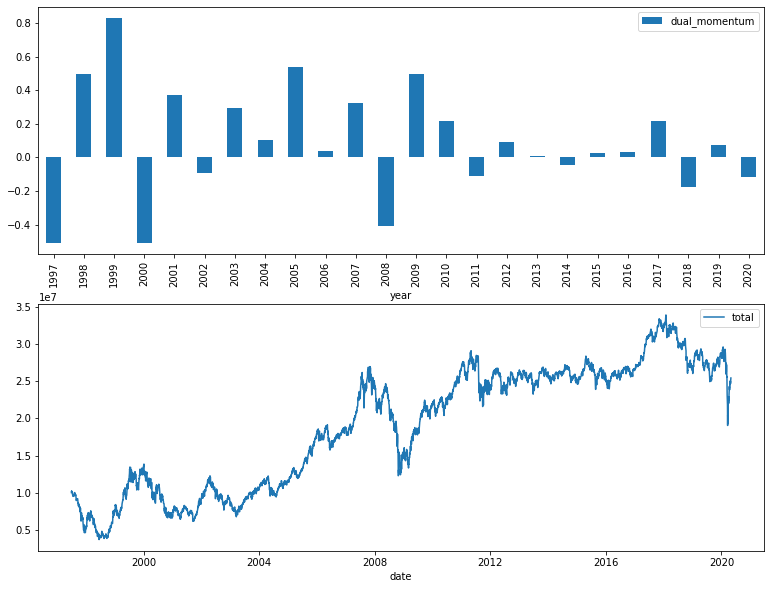

In [35]:
plt.rcParams["figure.figsize"] = (13,10)
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


annual_return_df.plot.bar(ax=ax1)
positions_value_df[['total']].plot(ax=ax2)



